In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


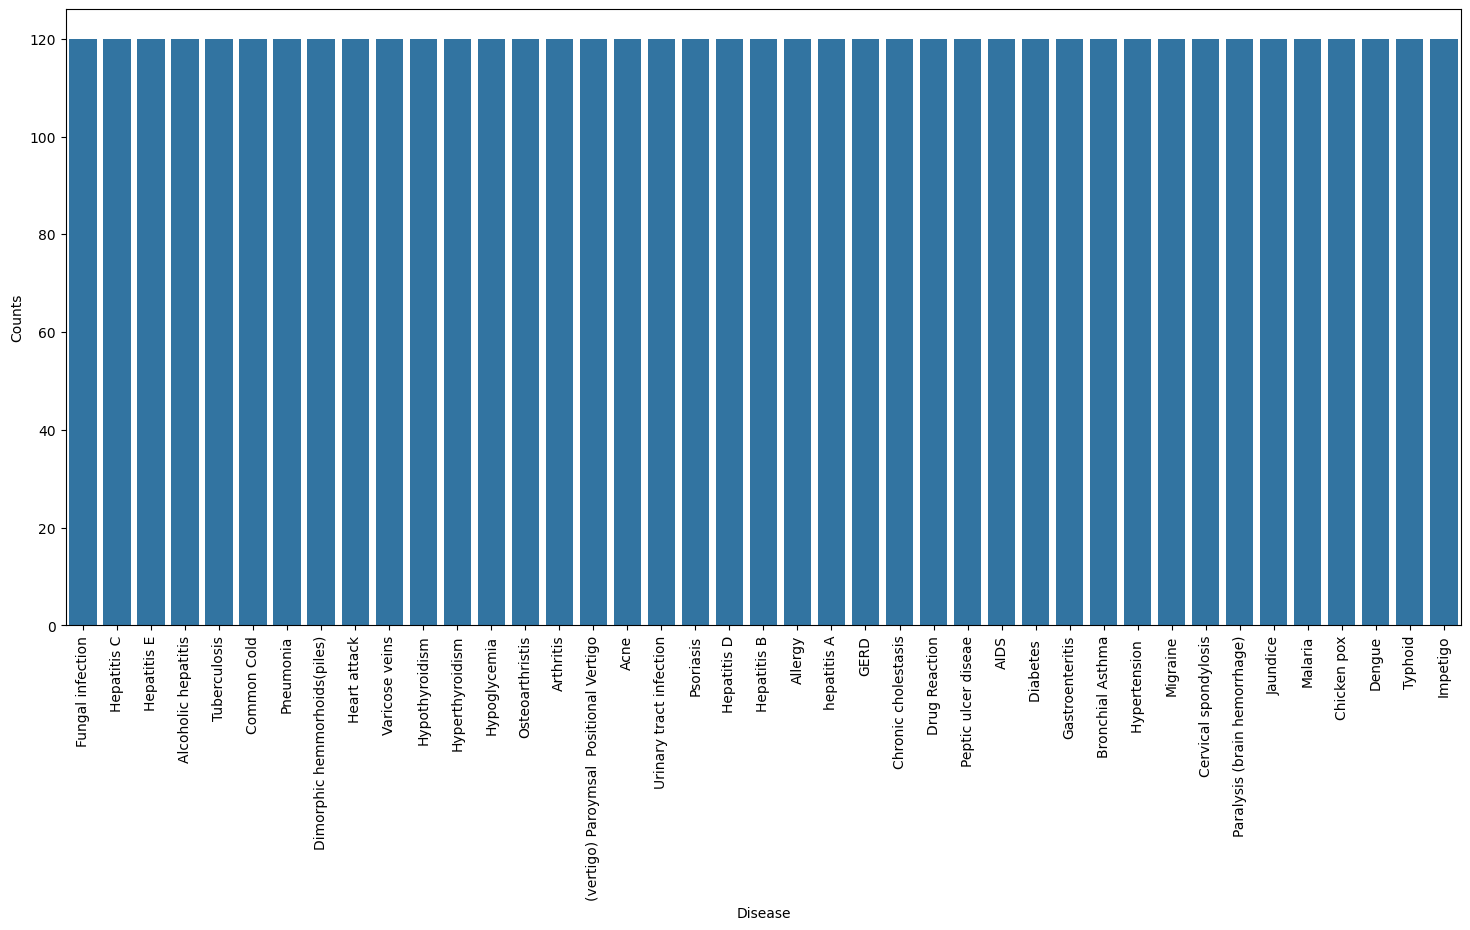

In [2]:
DATA_PATH = "data/Training.csv"
data = pd.read_csv(DATA_PATH).dropna(axis = 1)

disease_counts = data["prognosis"].value_counts()
temp_df = pd.DataFrame({
    "Disease" : disease_counts.index,
    "Counts": disease_counts.values
})

plt.figure (figsize = (18,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation = 90)
plt.show()

In [3]:
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])

In [23]:
x = data.iloc[:,:-1]
y = data.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 24)

print(f"Train: {x_train.shape},{y_train.shape}")
print(f"Test: {x_test.shape},{y_test.shape}")

Train: (3936, 132),(3936,)
Test: (984, 132),(984,)


In [5]:
def cv_scoring(estimator, x, y):
    return accuracy_score(y, estimator.predict(x))

models = {
    "SVC": SVC(),
    "Gaussian NB": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state = 18)

}

for model_name in models:
    model = models[model_name]
    scores = cross_val_score(model, x, y, cv = 10, n_jobs = -1, scoring = cv_scoring)

    print("==" * 30)
    print(model_name)
    print(f"Scores:{scores}")
    print (f"Mean Score {np.mean(scores)}")

SVC
Scores:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score 1.0
Gaussian NB
Scores:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score 1.0
Random Forest
Scores:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score 1.0


Accuracy on train data by SVM Classifier: 100.0
Accuracy on test daya by SVM Classifier: 100.0


Text(0.5, 1.0, 'Confusion Matrix for SVM Classifier on Test Data')

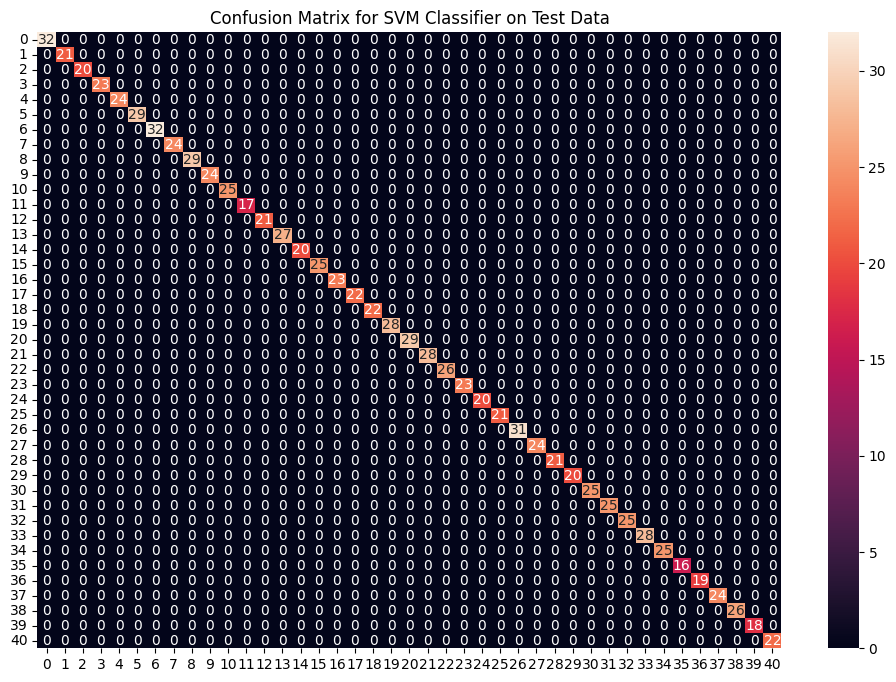

In [6]:
svm_model = SVC()
svm_model.fit(x_train, y_train)
preds = svm_model.predict(x_test)

print(f"Accuracy on train data by SVM Classifier: {accuracy_score(y_train, svm_model.predict(x_train))*100}")

print(f"Accuracy on test daya by SVM Classifier: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test,preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for SVM Classifier on Test Data")

Accuracy on train data by Naive Bayes Classifier: 100.0
Accuracy on test data by Naive Bayes Classifier: 100.0


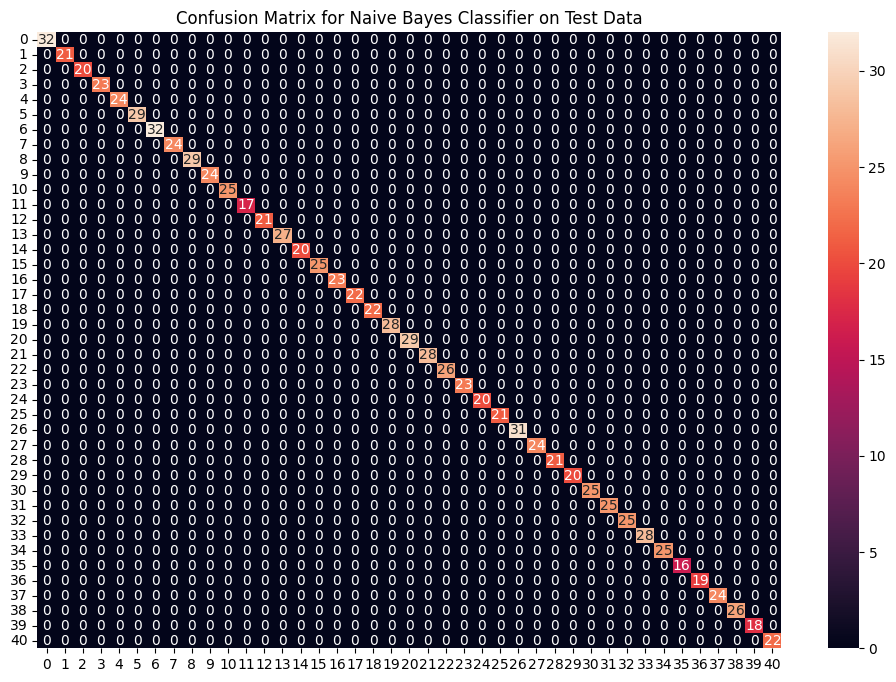

In [7]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
preds = nb_model.predict(x_test)
print(f"Accuracy on train data by Naive Bayes Classifier: {accuracy_score(y_train, nb_model.predict(x_train))*100}")

print (f"Accuracy on test data by Naive Bayes Classifier: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8))
sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for Naive Bayes Classifier on Test Data")
plt.show()

Accuracy on train data by Random Forest Classifier: 100.0
Accuracy on test data by Random Forest Classifier: 100.0


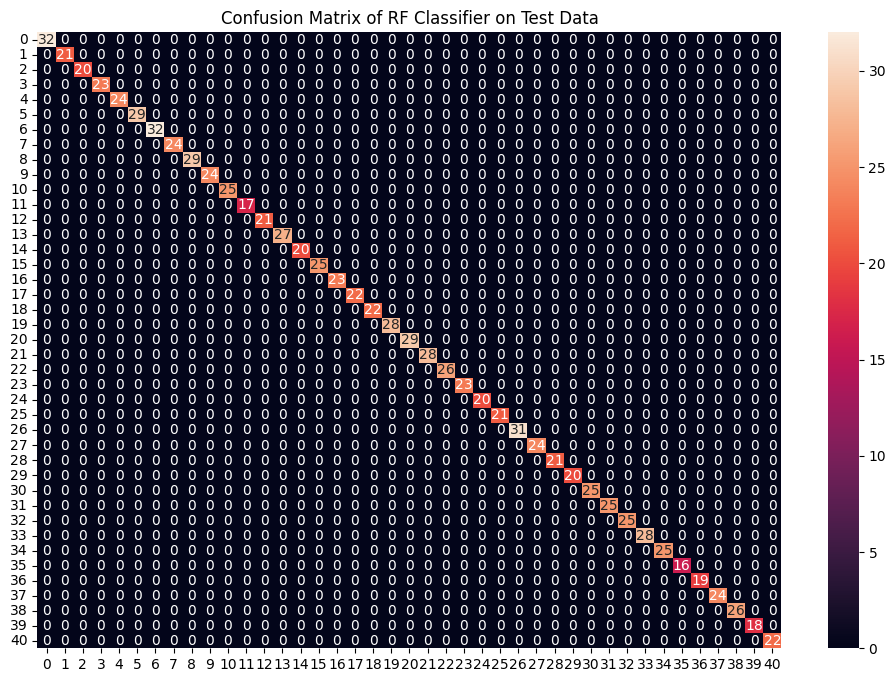

In [20]:
rf_model = RandomForestClassifier(random_state = 18)
rf_model.fit(x_train, y_train)
preds = rf_model.predict(x_test)
print (f"Accuracy on train data by Random Forest Classifier: {accuracy_score(y_train, rf_model.predict(x_train))*100}")

print (f"Accuracy on test data by Random Forest Classifier: {accuracy_score(y_test, preds)*100}")

cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8))
sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix of RF Classifier on Test Data")
plt.show()

Accuracy on Test dataset by combined model: 100.0


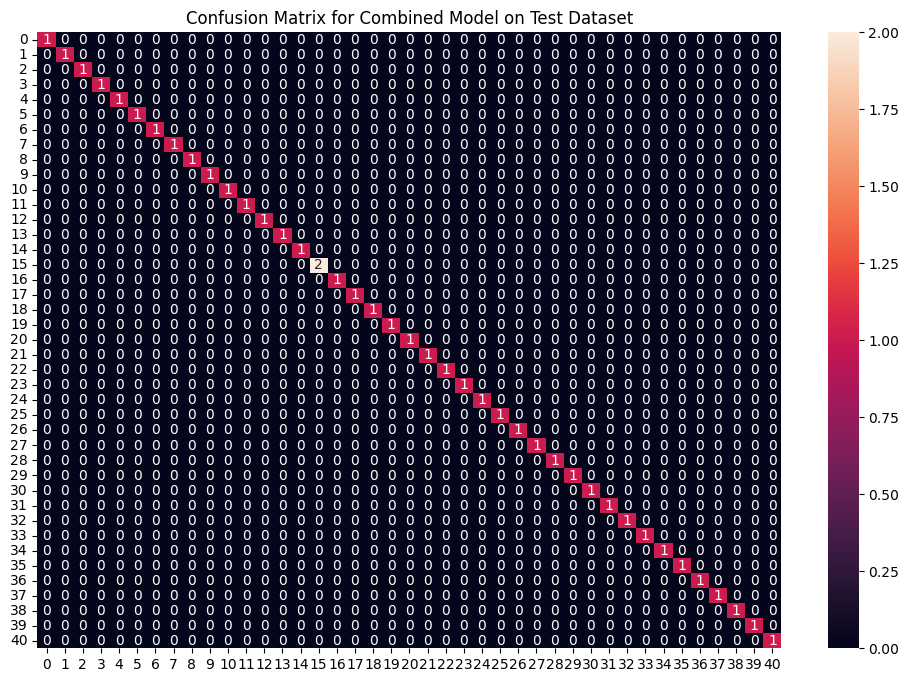

In [30]:
final_svm_model = SVC()
final_nb_model = GaussianNB()
final_rf_model = RandomForestClassifier(random_state=18)
final_svm_model.fit(x.values, y.values)
final_nb_model.fit(x.values, y.values)
final_rf_model.fit(x.values, y.values)

test_data = pd.read_csv("data/Testing.csv").dropna(axis=1)

test_x = test_data.iloc[:, :-1]
test_y = encoder.transform(test_data.iloc[:, -1])

svm_preds = final_svm_model.predict(test_x.values)
nb_preds = final_nb_model.predict(test_x.values)
rf_preds = final_rf_model.predict(test_x.values)

from scipy import stats

final_preds = [stats.mode([i,j,k])[0] for i,j,k in zip(svm_preds,nb_preds,rf_preds)]

print(f"Accuracy on Test dataset by combined model: {accuracy_score(test_y, final_preds)*100}")

cf_matrix = confusion_matrix(test_y, final_preds)
plt.figure(figsize = (12,8))
sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()

In [31]:
symptoms = x.columns.values

symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index

data_dict = {
    "Symptom_index" : symptom_index,
    "Predictions_classes": encoder.classes_
}

def predictDisease(symptoms):
    symptoms = symptoms.split(",")
    input_data = [0] * len(data_dict["Symptom_index"])
    for symptom in symptoms:
        index = data_dict["Symptom_index"][symptom]
        input_data[index] = 1
    input_data = np.array(input_data).reshape(1,-1)

    rf_prediction = data_dict["Predictions_classes"][final_rf_model.predict(input_data)[0]]
    nb_prediction = data_dict["Predictions_classes"][final_nb_model.predict(input_data)[0]]
    svm_prediction = data_dict["Predictions_classes"][final_svm_model.predict(input_data)[0]]

    import statistics 
    final_prediction = statistics.mode([rf_prediction, nb_prediction, svm_prediction])
    predictions = {
        "rf_model_prediction": rf_prediction,
        "naive_bayes_prediction": nb_prediction,
        "svm_model_prediction": svm_prediction,
        "final_prediction": final_prediction
    }
    return predictions

print(predictDisease("Itching,Skin Rash,Nodal Skin Eruptions"))

{'rf_model_prediction': 'Fungal infection', 'naive_bayes_prediction': 'Fungal infection', 'svm_model_prediction': 'Fungal infection', 'final_prediction': 'Fungal infection'}
